In [433]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit 
from qiskit.quantum_info.operators import Operator
import numpy as np
import scipy.linalg as la

In [434]:
# from qiskit import QuantumCircuit, QuantumRegister
# import numpy as np

# def prepare_quantum_state(probabilities):
#     num_states = len(probabilities)
#     num_qubits = int(np.ceil(np.log2(num_states)))
    
#     # Create a quantum circuit with the required number of qubits
#     qr = QuantumRegister(num_qubits)
#     qc = QuantumCircuit(qr)
    
#     # Calculate the amplitudes based on the probabilities
#     amplitudes = np.sqrt(probabilities)
    
#     # Normalize the amplitudes
#     amplitudes /= np.linalg.norm(amplitudes)
    
#     # Apply state preparation gates
#     for i in range(num_states):
#         binary = np.binary_repr(i, width=num_qubits)
#         for j in range(num_qubits):
#             if binary[j] == '1':
#                 qc.ry(2 * np.arccos(amplitudes[i]), qr[j])
#             else:
#                 qc.ry(2 * np.arcsin(amplitudes[i]), qr[j])
#     qc.measure_all()
#     return qc

# # Example usage
# probabilities = [0.2, 0.3, 0.1, 0.4]
# qc = prepare_quantum_state(probabilities)
# qc.draw()

In [435]:
# from qiskit_aer import AerSimulator
# from qiskit.circuit import QuantumCircuit
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
# aer = AerSimulator()

# aer.run(qc).result().get_counts()


In [436]:
vals = {
    1: 0.2,
    3: 0.35,
    7: 0.45
}

In [437]:
max_val = max(vals.keys())
nbits = len(bin(max_val)) - 2
print(nbits)

3


In [438]:
# # Create a quantum circuit with two qubits
# qc = QuantumCircuit(nbits)

# # Convert the desired probabilities to a state vector
# state_vector = [np.sqrt(p) for p in vals.values()]
# state_vector = np.array(state_vector) * np.exp(1j * 0)  # Add a global phase factor of 0

# # Initialize the circuit to the desired state
# qc.initialize(state_vector, [0, 1])

# qc.measure_all()

# # Draw the circuit
# qc.draw()

In [439]:
# from qiskit_aer import AerSimulator
 
# aer = AerSimulator()

# counts = aer.run(qc).result().get_counts()
# dict(counts)
# for k, v in counts.items():
#     print(int(k, 2), v/1024)

In [440]:
qreg_q = QuantumRegister(nbits, 'q')
# creg_c = ClassicalRegister(1, 'c')
qc = QuantumCircuit(qreg_q)

In [441]:
def create_unitary(v):
    dim = v.size
    # Return identity if v is a multiple of e1
    if v[0][0] and not np.any(v[0][1:]):
        return np.identity(dim)
    e1 = np.zeros(dim)
    e1[0] = 1
    w = v/np.linalg.norm(v) - e1
    return np.identity(dim) - 2*((np.dot(w.T, w))/(np.dot(w, w.T)))

In [442]:
def unitary_from_column(column_vector):
    """
    Constructs a unitary matrix with the given column vector as the first column.
    
    Args:
        column_vector (numpy.ndarray): A column vector.
        
    Returns:
        numpy.ndarray: A unitary matrix with the given column vector as the first column.
    """
    n = len(column_vector)
    
    # Normalize the column vector
    u1 = column_vector / np.linalg.norm(column_vector)
    
    # Initialize the unitary matrix with the first column
    unitary_matrix = np.array([u1]).T
    
    # Construct the remaining columns using the Gram-Schmidt process
    for j in range(1, n):
        v = np.random.randn(n)  # Start with a random vector
        for i in range(j):
            proj = np.dot(unitary_matrix[:, i], v) * unitary_matrix[:, i]
            v = v - proj
        uj = v / np.linalg.norm(v)
        unitary_matrix = np.c_[unitary_matrix, uj]
    
    return unitary_matrix

In [443]:
v = np.array([np.sqrt(vals.get(i, 0)) for i in range(2**nbits)])
unitary = unitary_from_column(v)
print(unitary)
op = Operator(unitary)
print(unitary.shape)

[[ 0.         -0.11876701  0.42961347  0.47017084  0.0373914   0.26862134
   0.61825711 -0.35280115]
 [ 0.4472136  -0.44839393 -0.30213282  0.03949407 -0.12232104 -0.00092011
  -0.26795163 -0.64756274]
 [ 0.          0.43007703  0.44492545  0.10319344 -0.6115937   0.09012013
  -0.42564293 -0.20757125]
 [ 0.59160798  0.47238782 -0.08054492  0.4746805   0.29922622 -0.30389609
  -0.03873397  0.10794076]
 [ 0.         -0.08276773  0.28908417  0.05671727  0.59061997  0.5399749
  -0.51502132  0.02666837]
 [ 0.         -0.57113294  0.14143398  0.51038103 -0.25460474 -0.17308511
  -0.22017629  0.50005516]
 [ 0.         -0.17271197  0.58471916 -0.28233962  0.27046425 -0.65854139
  -0.06543521 -0.1935174 ]
 [ 0.67082039 -0.11767761  0.27245582 -0.44495823 -0.18234536  0.26862456
   0.21279457  0.33651369]]
(8, 8)


In [444]:
def is_unitary(matrix):
    """
    Checks if a given matrix is unitary.
    
    Args:
        matrix (numpy.ndarray): The input matrix.
        
    Returns:
        bool: True if the matrix is unitary, False otherwise.
    """
    # Check if the matrix is square
    if matrix.shape[0] != matrix.shape[1]:
        print("not square")
        return False
    
    # Compute the inverse and conjugate transpose
    try:
        inv_matrix = np.linalg.inv(matrix)
        conj_trans_matrix = np.conj(matrix.T)
    except np.linalg.LinAlgError:
        # If the matrix is not invertible, it cannot be unitary
        print("not invertible")
        return False
    
    # Check if the inverse is equal to the conjugate transpose
    if np.allclose(inv_matrix, conj_trans_matrix):
        return True
    else:
        print("not equal")
        return False
    
is_unitary(unitary)

True

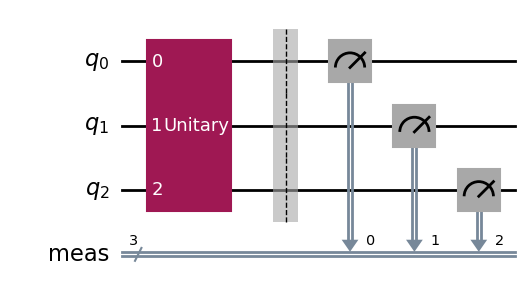

In [445]:
qc.append(op, qreg_q)
qc.measure_all()
qc.draw()

In [458]:
from qiskit_aer import AerSimulator
 
aer = AerSimulator()

counts = aer.run(qc).result().get_counts()
dict(counts)
for k, v in counts.items():
    print(int(k, 2), v/1024)

1 0.1728515625
3 0.3662109375
7 0.4609375


In [450]:
df = np.empty((len(vals), nbits))
keys = list(vals.keys())
for i in range(len(vals)):
    df[i] = list(f'{keys[i]:>0{nbits}b}')
print(df)
sums = np.sum(df, axis=0)
p = sums / len(vals)
p

[[0. 0. 1.]
 [0. 1. 1.]
 [1. 1. 1.]]


array([0.33333333, 0.66666667, 1.        ])

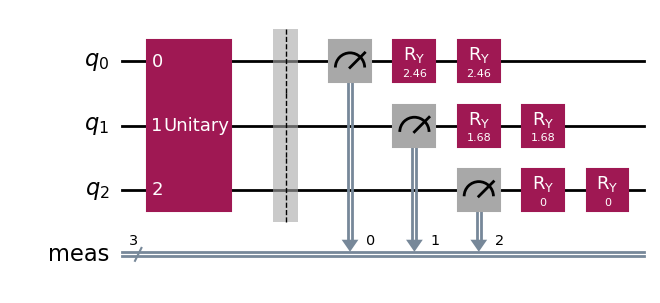

In [451]:
for i in range(nbits):
    if p[i] == 0:
        continue
    qc.ry(2 * np.arccos(p[i]), i)
qc.draw()